In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import ops
from keras import layers, models
from keras import backend as K
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
def format_img(id):
    # Charger l'image et la transformer en tableau numpy
    image = Image.open(f'./img_test/{id}.jpg')
    # Choisissez une nouvelle résolution plus petite
    img_resized = image.resize((128, 128)) # Attention taille de l'image 128x128

    # -1 pour aplatir l'image, 3 pour les canaux RGB
    image_np = np.array(img_resized) # ne pas aplatir
    #image_gris=img_resized.convert('L')

    # Normaliser les valeurs des pixels
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    #image_np_normalized = scaler.fit_transform(image_np)

    # Données d'entraînement
    #Portrait = image_np_normalized
    #return image_gris
    return image_np

data=[]
for i in range(1,1000):
    if i <10:
        id=f'00000{i}'
        data.append(format_img(id))
    if i<100 and i>=10:
        id=f'0000{i}'
        data.append(format_img(id))
    if i<1000 and i>=100:
        id=f'000{i}'
        data.append(format_img(id))
    if i>=1000:
        id=f'00{i}'
        data.append(format_img(id))
data=np.array(data)
print(data.shape)

"""
plt.imshow(data[0], cmap='gray_r')
plt.axis("off")
plt.show()
"""
attributes = np.loadtxt("list_attr_celeba.txt", skiprows=2, dtype='str')
attributes_short = attributes[0:999]
genre = np.array(attributes_short[:,21], dtype=int)

print('Data OK')

(999, 128, 128, 3)
Data OK


In [107]:
from keras import Model, Input

latent_dim = 8  #  latent space dimension

def build_encoder(input_shape=(128, 128, 3)):
    img_input = Input(shape=input_shape, name="encoder_image_input")
    label_input = Input(shape=(1,), name="encoder_label_input")

    # Broadcast -1/1 labels to shape=(128,128,1)
    x_label = layers.Dense(128 * 128)(label_input)
    x_label = layers.Reshape((128, 128, 1))(x_label)

    x = layers.Concatenate(axis=-1)([img_input, x_label])

    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z_log_var = layers.Lambda(lambda t: tf.clip_by_value(t, -10.0, 2.0))(z_log_var)



    # Sampling layer
    def sampling(args):
        z_mean, z_log_var = args
        eps = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    gender_logits = layers.Dense(1, activation="tanh")(z)  # output interval [-1, 1]


    encoder = Model([img_input, label_input], [z_mean, z_log_var, z, gender_logits], name="encoder")
    return encoder

In [108]:
def build_decoder(output_shape=(128, 128, 3)):
    latent_input = Input(shape=(latent_dim,), name="decoder_latent_input")
    label_input = Input(shape=(1,), name="decoder_label_input")

    # put latent and label together
    x = layers.Concatenate()([latent_input, label_input])
    x = layers.Dense(8 * 8 * 256, activation="relu")(x)
    x = layers.Reshape((8, 8, 256))(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)

    output_img = layers.Conv2DTranspose(output_shape[2], 3, activation="sigmoid", padding="same")(x)

    decoder = Model([latent_input, label_input], output_img, name="decoder")
    return decoder

In [109]:
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        images, labels = data  
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z, gender_logits = self.encoder([images, labels])
            reconstruction = self.decoder([z, labels])

            # Calculate MSE
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(images, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            labels = tf.cast(labels, tf.float32)
            # Add gender_loss as a study factor
            gender_loss = tf.reduce_mean(tf.square(gender_logits - labels))  # labels: -1/1
            total_loss = reconstruction_loss + kl_loss + 1.0 * gender_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "gender_loss": gender_loss,
        }

In [110]:
encoder = build_encoder(input_shape=(128, 128, 3))
decoder = build_decoder(output_shape=(128, 128, 3))
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_label_input           │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_32 (Dense)              │ (None, 16384)             │          32,768 │ encoder_label_input[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_image_input           │ (None, 128, 128, 3)       │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_19 (Reshape)          │ (None, 128, 128, 1)       │               0 │ dense_32[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_19 (Concatenate)  │ (None, 128, 128, 4)       │               0 │ encoder_image_input[0][0], │
│                               │                           │                 │ reshape_19[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_41 (Conv2D)            │ (None, 64, 64, 32)        │           1,184 │ concatenate_19[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_42 (Conv2D)            │ (None, 32, 32, 64)        │          18,496 │ conv2d_41[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_43 (Conv2D)            │ (None, 16, 16, 128)       │          73,856 │ conv2d_42[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_44 (Conv2D)            │ (None, 8, 8, 256)         │         295,168 │ conv2d_43[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_10 (Flatten)          │ (None, 16384)             │               0 │ conv2d_44[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_33 (Dense)              │ (None, 512)               │       8,389,120 │ flatten_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_log_var (Dense)             │ (None, 8)                 │           4,104 │ dense_33[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_mean (Dense)                │ (None, 8)                 │           4,104 │ dense_33[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_4 (Lambda)             │ (None, 8)                 │               0 │ z_log_var[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z (Lambda)                    │ (None, 8)                 │               0 │ z_mean[0][0],              │
│                               │                           │                 │ lambda_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 8,818,809 (33.64 MB)

 Trainable params: 8,818,809 (33.64 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_latent_input          │ (None, 8)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_label_input           │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_20 (Concatenate)  │ (None, 9)                 │               0 │ decoder_latent_input[0][0… │
│                               │                           │                 │ decoder_label_input[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_35 (Dense)              │ (None, 16384)             │         163,840 │ concatenate_20[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_20 (Reshape)          │ (None, 8, 8, 256)         │               0 │ dense_35[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_40           │ (None, 16, 16, 128)       │         295,040 │ reshape_20[0][0]           │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_41           │ (None, 32, 32, 64)        │          73,792 │ conv2d_transpose_40[0][0]  │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_42           │ (None, 64, 64, 32)        │          18,464 │ conv2d_transpose_41[0][0]  │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_43           │ (None, 128, 128, 16)      │           4,624 │ conv2d_transpose_42[0][0]  │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_44           │ (None, 128, 128, 3)       │             435 │ conv2d_transpose_43[0][0]  │
│ (Conv2DTranspose)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 556,195 (2.12 MB)

 Trainable params: 556,195 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

In [123]:
x_train, x_test, y_train, y_test = train_test_split(data, genre, test_size=0.33, random_state=42)
x_t = x_train/255
print(y_train[0:99])

[-1 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1  1  1 -1 -1 -1 -1  1  1  1 -1  1 -1
 -1 -1  1  1  1  1 -1 -1  1  1 -1 -1 -1  1 -1 -1  1 -1  1  1  1  1 -1 -1
 -1 -1  1  1  1  1  1 -1 -1  1  1  1  1  1  1 -1 -1 -1  1 -1 -1  1 -1 -1
 -1 -1  1]


In [124]:
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=keras.optimizers.Adam(clipnorm=1.0))
cvae.fit(x_t, y_train, epochs=100, batch_size=32)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - gender_loss: 0.9790 - kl_loss: 2.2179e-05 - loss: 6461.9360 - reconstruction_loss: 6460.9585
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - gender_loss: 0.9801 - kl_loss: 1.2848e-06 - loss: 6383.5293 - reconstruction_loss: 6382.5488
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - gender_loss: 0.9794 - kl_loss: 2.1337e-06 - loss: 6489.7095 - reconstruction_loss: 6488.7319
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - gender_loss: 0.9733 - kl_loss: 2.4801e-06 - loss: 6519.5356 - reconstruction_loss: 6518.5635
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - gender_loss: 0.9779 - kl_loss: 9.5160e-07 - loss: 6554.6318 - reconstruction_loss: 6553.6411
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - gender_loss: 0.9731 - kl_loss: 7.8652e-07 - loss: 6491.6357 - reconstruction_loss: 6490.6670
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - gender_loss: 0.9803 - kl_loss: 4.2526e-06 - loss: 6463.48

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - gender_loss: 0.9784 - kl_loss: 24.0291 - loss: 478.9747 - reconstruction_loss: 453.9618
Epoch 47/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - gender_loss: 0.9813 - kl_loss: 25.0703 - loss: 465.7694 - reconstruction_loss: 439.7415
Epoch 48/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - gender_loss: 0.9754 - kl_loss: 23.9729 - loss: 463.4098 - reconstruction_loss: 438.4654
Epoch 49/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - gender_loss: 0.9775 - kl_loss: 24.4153 - loss: 470.0005 - reconstruction_loss: 444.6109
Epoch 50/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - gender_loss: 0.9782 - kl_loss: 24.5092 - loss: 462.3841 - reconstruction_loss: 436.8996
Epoch 51/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - gender_loss: 0.9783 - kl_loss: 24.3080 - loss: 460.7680 - reconstruction_loss: 435.4930
Epoch 52/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - gender_loss: 0.9771 - kl_loss: 23.8107 - loss: 456.7796 - reconstruction_loss: 431.9937
Epoch

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - gender_loss: 0.9781 - kl_loss: 25.4325 - loss: 369.2840 - reconstruction_loss: 342.8665
Epoch 93/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - gender_loss: 0.9763 - kl_loss: 25.1112 - loss: 364.1446 - reconstruction_loss: 338.0481
Epoch 94/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - gender_loss: 0.9760 - kl_loss: 25.6721 - loss: 369.9877 - reconstruction_loss: 343.3462
Epoch 95/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - gender_loss: 0.9772 - kl_loss: 24.9689 - loss: 367.7690 - reconstruction_loss: 341.8059
Epoch 96/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - gender_loss: 0.9740 - kl_loss: 24.7175 - loss: 369.3834 - reconstruction_loss: 343.6855
Epoch 97/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - gender_loss: 0.9771 - kl_loss: 24.8248 - loss: 373.0459 - reconstruction_loss: 347.2430
Epoch 98/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - gender_loss: 0.9794 - kl_loss: 25.1906 - loss: 362.0236 - reconstruction_loss: 335.8644
Epoch

In [125]:
z_mean, _, _, _ = cvae.encoder.predict([x_test, y_test], batch_size=32)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [126]:
import numpy as np

nan_rows = np.any(np.isnan(z_mean), axis=1)
print(f"Nb of samples containing NaN ：{np.sum(nan_rows)} / {len(z_mean)}")


Nb of samples containing NaN ：0 / 330


In [127]:
print(z_mean[:1])

[[-71.61685  135.87245   16.704817 153.58836  111.01606  -62.672173
  118.70818  -57.1293  ]]


In [128]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# z_fixed = np.nan_to_num(z_mean, nan=0.0)  # replace all NaN by 0.0


# t-SNE (for decreasing the dimension, can also use PCA)
z_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(z_mean)


C:\Users\degab\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\degab\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


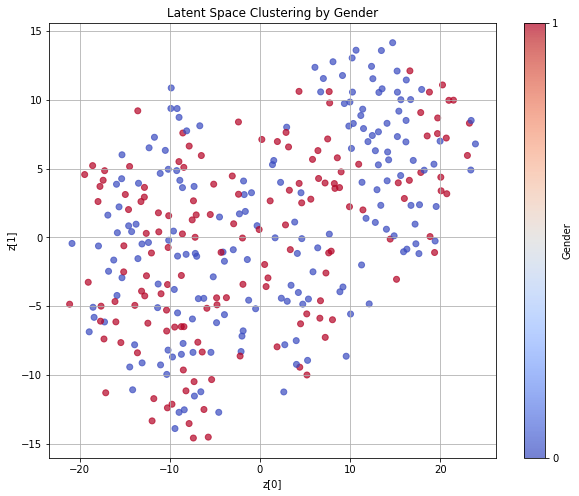

In [129]:
y_colormap = (y_test.flatten() + 1) // 2

plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_colormap, cmap="coolwarm", alpha=0.7)
plt.colorbar(scatter, ticks=[0, 1], label="Gender")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space Clustering by Gender")
plt.grid(True)
plt.show()

# The gender clusters are not well seperated, but I tried to generate male/female images and it seems to be not bad...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


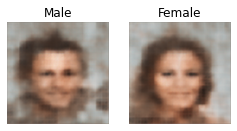

In [186]:
import numpy as np
import matplotlib.pyplot as plt

# generate a random latent z
latent_dim = 8  
z_sample = np.random.normal(size=(1, latent_dim))

# condition label：-1 = female，1 = male
label_male = np.array([[1]])
label_female = np.array([[-1]])

# generate male/female image
img_male = cvae.decoder.predict([z_sample, label_male])
img_female = cvae.decoder.predict([z_sample, label_female])

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.title("Male")
plt.imshow(img_male[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Female")
plt.imshow(img_female[0])
plt.axis('off')
plt.show()